In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np
import matplotlib.pyplot as plt

from epymorph.attribute import NamePattern


duration = 7 * 14
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", 7 * 14),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [2]:
rume.time_frame.end_date

datetime.date(2023, 1, 6)

In [3]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./doc/devlog/data/14week_temp_synthetic_data.csv"),
    time_col=0,
    time_frame=rume.time_frame,
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [4]:
from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=quantity_selection,
        time=time_selection,
        geo=geo_selection,
    ),
    likelihood=Poisson(),
)

filter_type = ParticleFilter(num_particles=500)

In [5]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.utils.parameter_estimation import (
    EstimateParameters,
    ForecastParameters,
)

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
}

In [6]:
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

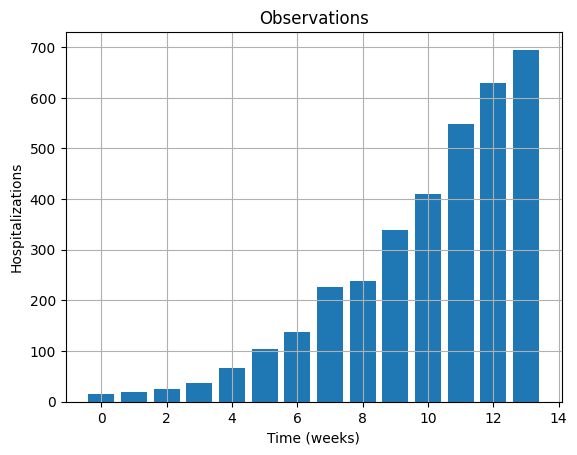

In [7]:
plt.bar(range(len(sim.cases)), sim.cases[:, 0])
plt.title("Observations")
plt.xlabel("Time (weeks)")
plt.ylabel("Hospitalizations")
plt.grid(True)
plt.show()

In [8]:
rng = np.random.default_rng(seed=1)
output = sim.run(rng=rng)

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2022-12-31 00:00:00 (98 days)
• 500 particles

Simulation completed in 78.17s

Parameters estimated: ['beta']


In [9]:
output.model_data

array([[  1],
       [ 12],
       [ 47],
       [ 68],
       [ 75],
       [ 99],
       [143],
       [206],
       [384],
       [311],
       [462],
       [496],
       [711],
       [725]])

In [10]:
forecast_params_space = {
    "beta": ForecastParameters.TimeVarying(
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
}

In [11]:
quantity_selection = rume.ipm.select.events("S->I")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

get_model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [12]:
from epymorph.parameter_forecasting.forecast_class import ForecastSimulation


sim = ForecastSimulation(
    initial_particles=output.particles,
    rume=rume,
    params_space=forecast_params_space,
    model_link=observations.model_link,
    duration=40,
    request_data={
        "quantity": get_model_link,
        # "particle_cloud": ["2023-01-20", "2023-02-10"],
    },
)

In [ ]:
forecast_output = sim.run()

start: 2023-01-13---particles: [[6270898   40034  330493     503]]
start: 2023-01-20---particles: [[6208625   39530  393294     479]]
start: 2023-01-27---particles: [[6156972   34306  450182     468]]
start: 2023-02-03---particles: [[6118815   27135  495574     404]]
start: 2023-02-10---particles: [[6093731   20228  527663     306]]
start: 2023-02-17---particles: [[6079400   14216  548087     225]]
start: 2023-02-24---particles: [[6066440   13546  561733     209]]
start: 2023-03-03---particles: [[6055683   12423  573641     181]]
start: 2023-03-10---particles: [[6048897   10143  582733     155]]
start: 2023-03-17---particles: [[6042985    9461  589348     134]]
start: 2023-03-24---particles: [[6038686    8808  594327     107]]
start: 2023-03-31---particles: [[6039559    6093  596169     107]]
start: 2023-04-07---particles: [[6043553    4438  593858      79]]
start: 2023-04-14---particles: [[6051219    2241  588413      55]]
start: 2023-04-21---particles: [[6060365    1209  580330      

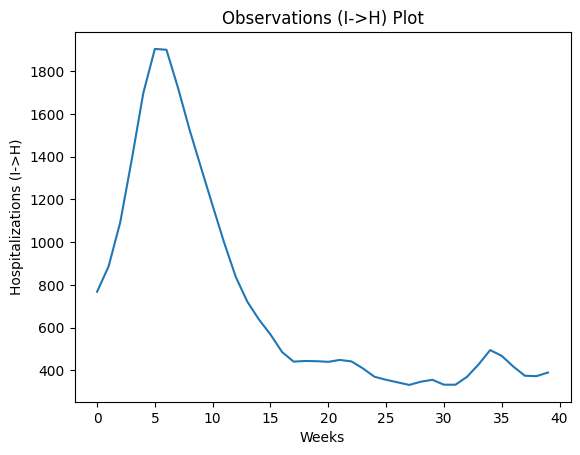

In [17]:
plt.plot(forecast_output.model_data)
plt.title("Observations (I->H) Plot")
plt.xlabel("Weeks")
plt.ylabel("Hospitalizations (I->H)")
plt.show()

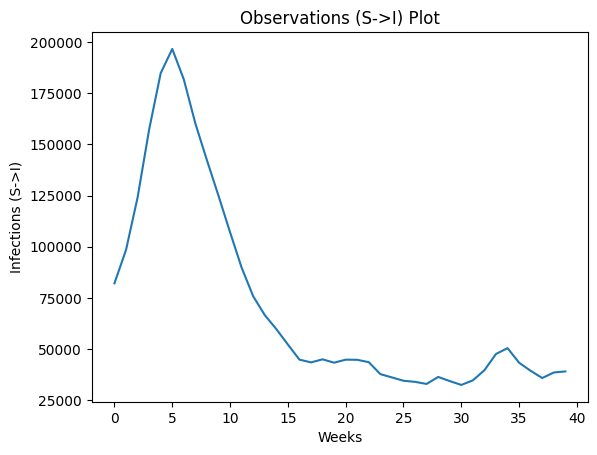

In [20]:
plt.plot(forecast_output.req_model_data)
plt.title("Observations (S->I) Plot")
plt.xlabel("Weeks")
plt.ylabel("Infections (S->I)")
plt.show()

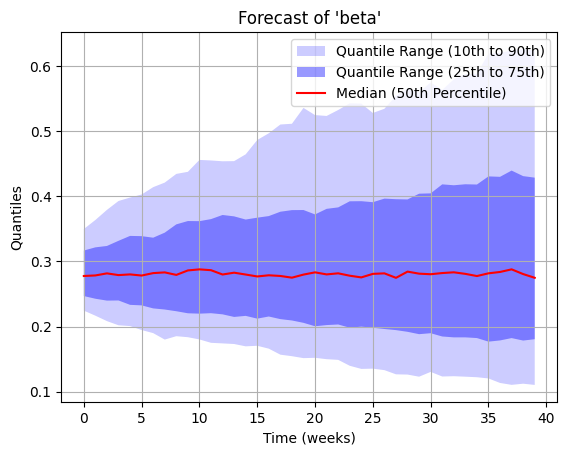

In [23]:
import matplotlib.pyplot as plt


key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

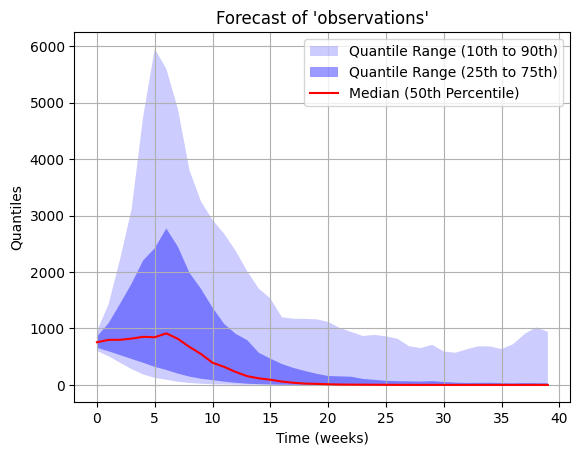

In [24]:
import matplotlib.pyplot as plt


key = "observations"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.model_data_quantiles)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [16]:
len(output.param_quantiles["beta"])

14

In [17]:
len(forecast_output.param_quantiles["beta"])

40

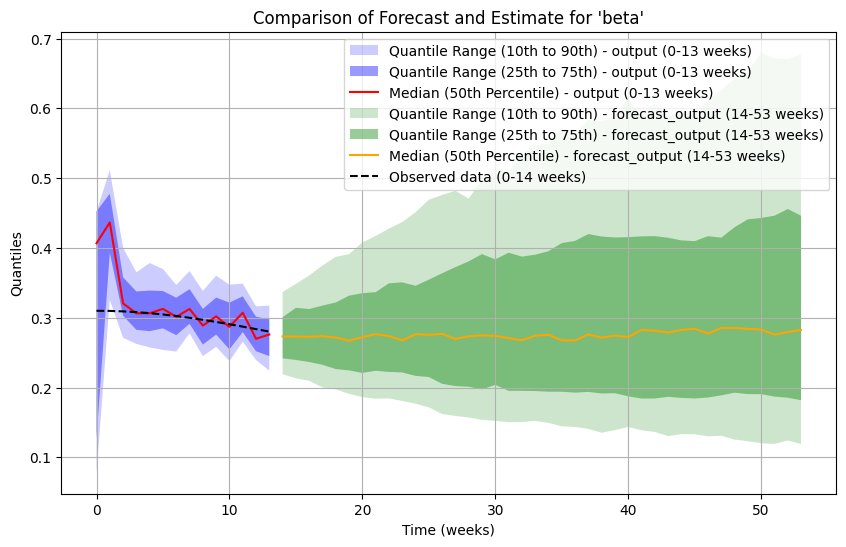

In [18]:
# Assuming output and forecast_output are already loaded as per your data.
key = "beta"
node_index = 0
truth = None

# First 14 weeks (from output)
key_quantiles_1 = np.array(output.param_quantiles[key])  # Data for weeks 0 to 13

# Next 40 weeks (from forecast_output)
key_quantiles_2 = np.array(
    forecast_output.param_quantiles[key]
)  # Data for weeks 14 to 53

# Create a plot for both datasets, for a total of 54 weeks (0-53)
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Combine both data sets' observed data if available
obs_0_13 = np.arange(0, 14)
plt.plot(
    obs_0_13,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
    label="Observed data (0-14 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


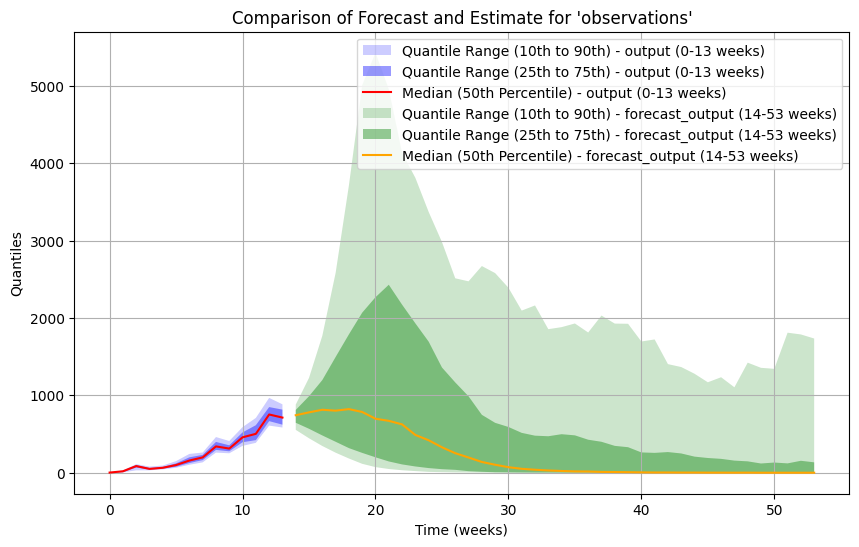

In [19]:
import matplotlib.pyplot as plt
import numpy as np

key = "observations"
node_index = 0
truth = None

# Get the quantiles for the two datasets
key_quantiles_1 = np.array(output.model_data_quantiles)  # Weeks 0 to 13 (output)
key_quantiles_2 = np.array(
    forecast_output.model_data_quantiles
)  # Weeks 14 to 53 (forecast_output)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


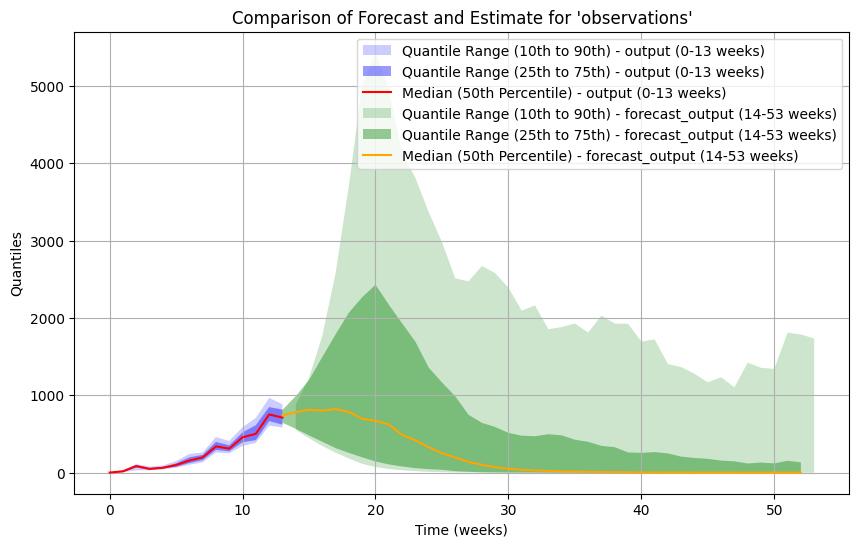

In [20]:
import matplotlib.pyplot as plt
import numpy as np

key = "observations"
node_index = 0
truth = None

# Get the quantiles for the two datasets
key_quantiles_1 = np.array(output.model_data_quantiles)  # Weeks 0 to 13 (output)
key_quantiles_2 = np.array(
    forecast_output.model_data_quantiles
)  # Weeks 14 to 53 (forecast_output)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(13, 53),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(13, 53),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


# Running the particle filter without running the particle filter

In [1]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 40
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [2]:
rume.time_frame.start_date

datetime.date(2022, 10, 1)

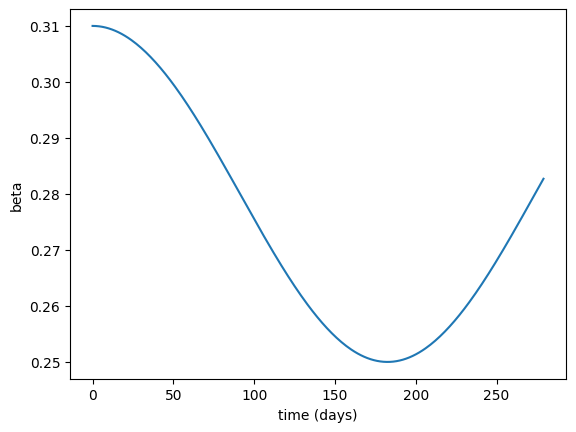

In [3]:
import matplotlib.pyplot as plt

plt.plot(t, true_beta)
plt.ylabel("beta")
plt.xlabel("time (days)")
# plt.ylim(0, 0.4)
plt.show()

In [8]:
from epymorph.parameter_fitting.utils.observations import ModelLink

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()


model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [9]:
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_forecasting.forecast_class import ForecastSimulation
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
    # "xi": EstimateParameters.Static(
    #     distribution=Uniform(a=0.001, b=0.01),
    #     perturbation=Calvetti(a=0.9),
    # ),
}


sim = ForecastSimulation(
    # initial_particles=output.particles,
    num_particles=500,
    rume=rume,
    params_space=params_space,
    model_link=model_link,
    duration=53,
)

In [ ]:
forecast_output_2 = sim.run()

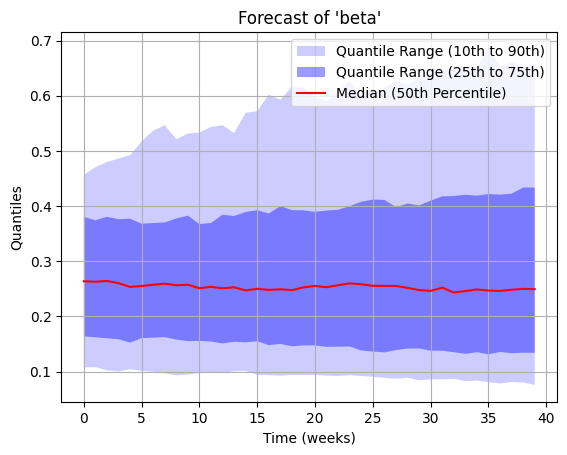

In [ ]:
import matplotlib.pyplot as plt


key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output_2.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

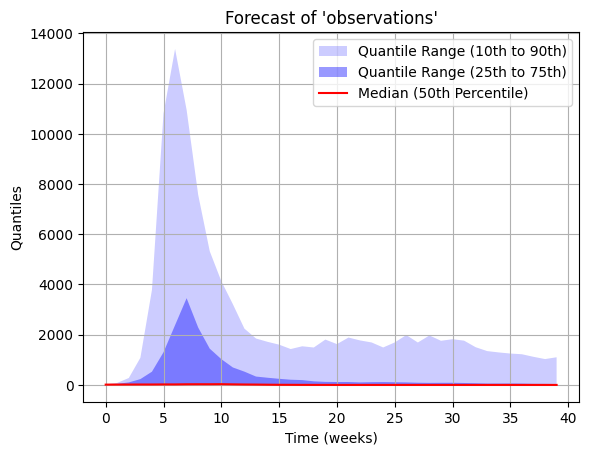

In [ ]:
import matplotlib.pyplot as plt


key = "observations"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output_2.model_data_quantiles)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

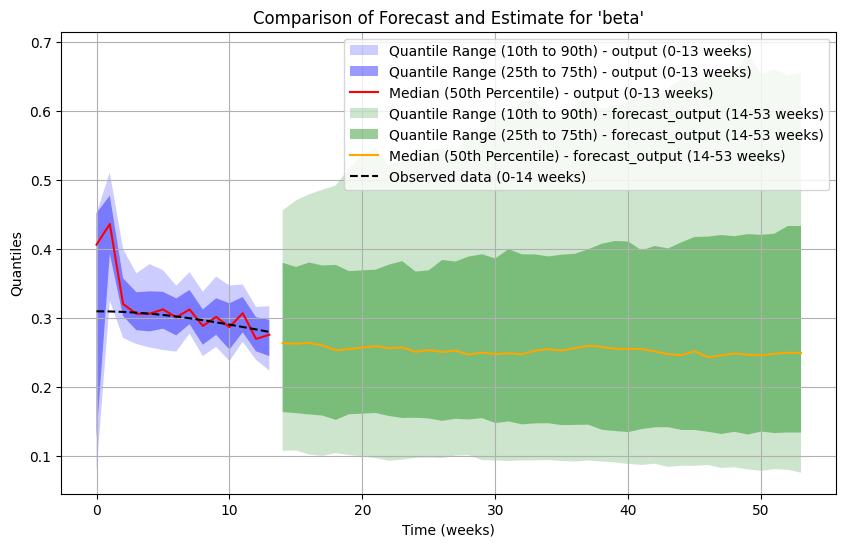

In [ ]:
# Assuming output and forecast_output are already loaded as per your data.
key = "beta"
node_index = 0
truth = None

# First 14 weeks (from output)
key_quantiles_1 = np.array(output.param_quantiles[key])  # Data for weeks 0 to 13

# Next 40 weeks (from forecast_output)
key_quantiles_2 = np.array(
    forecast_output_2.param_quantiles[key]
)  # Data for weeks 14 to 53

# Create a plot for both datasets, for a total of 54 weeks (0-53)
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Combine both data sets' observed data if available
obs_0_13 = np.arange(0, 14)
plt.plot(
    obs_0_13,
    np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
    "k--",
    label="Observed data (0-14 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


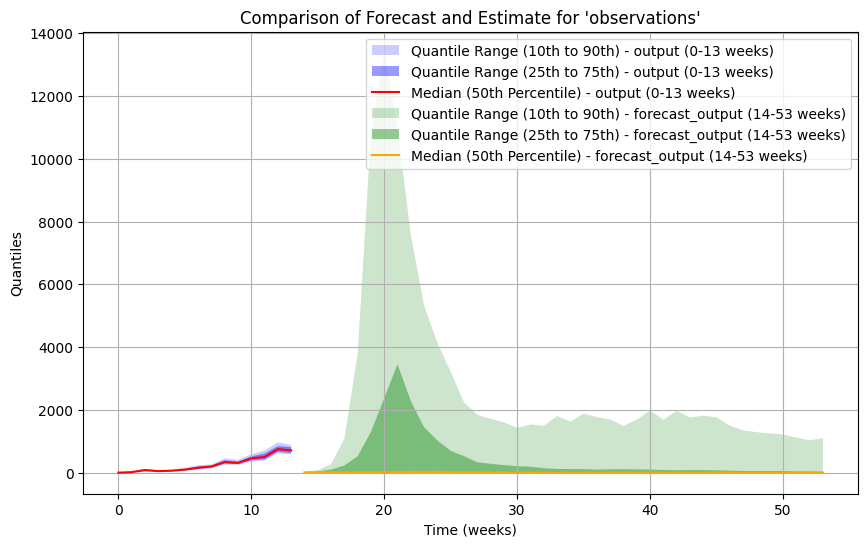

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

key = "observations"
node_index = 0
truth = None

# Get the quantiles for the two datasets
key_quantiles_1 = np.array(output.model_data_quantiles)  # Weeks 0 to 13 (output)
key_quantiles_2 = np.array(
    forecast_output_2.model_data_quantiles
)  # Weeks 14 to 53 (forecast_output)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot first dataset (output) for the first 14 weeks (0 to 13)
plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 3, 0],  # 10th Percentile
    key_quantiles_1[:, 22 - 3, 0],  # 90th Percentile
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - output (0-13 weeks)",
)

plt.fill_between(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 6, 0],  # 25th Percentile
    key_quantiles_1[:, 22 - 6, 0],  # 75th Percentile
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - output (0-13 weeks)",
)

plt.plot(
    np.arange(0, 14),  # Weeks 0-13
    key_quantiles_1[:, 11, 0],  # Median (50th Percentile)
    color="red",
    label="Median (50th Percentile) - output (0-13 weeks)",
)

# Plot second dataset (forecast_output) for the next 40 weeks (14 to 53)
plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 3, 0],  # 10th Percentile
    key_quantiles_2[:, 22 - 3, 0],  # 90th Percentile
    facecolor="green",
    alpha=0.2,
    label="Quantile Range (10th to 90th) - forecast_output (14-53 weeks)",
)

plt.fill_between(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 6, 0],  # 25th Percentile
    key_quantiles_2[:, 22 - 6, 0],  # 75th Percentile
    facecolor="green",
    alpha=0.4,
    label="Quantile Range (25th to 75th) - forecast_output (14-53 weeks)",
)

plt.plot(
    np.arange(14, 54),  # Weeks 14-53
    key_quantiles_2[:, 11, 0],  # Median (50th Percentile)
    color="orange",
    label="Median (50th Percentile) - forecast_output (14-53 weeks)",
)

# Title, labels, and legend
plt.title(f"Comparison of Forecast and Estimate for '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)

# Show the combined plot
plt.show()


In [ ]:
# sim = ForecastSimulation(
#     initial_particles=output.particles,
#     rume=rume,
#     params_space=params_space,
#     model_link=observations.model_link,
#     duration=40,
#     request_data={
#         model_data: model_link,
#         particle_cloud: [dates],
#         param_quantiles: [dates],
#     },
# )

In [ ]:
output.model_data